# 1. Импорт необходимых библиотек

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pywt  # Для работы с дискретным вейвлет-преобразованием
import seaborn as sns
from sklearn.metrics import confusion_matrix


В этом блоке мы импортируем все необходимые библиотеки и модули для обработки аудио, визуализации данных, построения и обучения модели нейронной сети, а также для оценки её производительности.

# 2. Определение функций для обработки данных

In [2]:
def convert_to_spectrogram(signal, sr, n_mels=128):
    """
    Преобразует аудиосигнал в мел-спектрограмму и затем в децибелы.
    """
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S


def pad_spectrogram(spectrogram, target_shape):
    """
    Дополняет или усекает спектрограмму до заданной формы.
    """
    if spectrogram.shape[1] < target_shape[1]:
        pad_width = target_shape[1] - spectrogram.shape[1]
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    else:
        padded_spectrogram = spectrogram[:, :target_shape[1]]
    return padded_spectrogram


def apply_wavelet_transform(signal, wavelet='db4', level=4):
    """
    Применяет дискретное вейвлет-преобразование к аудиосигналу.
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs


def frame_signal(signal, frame_size, hop_length):
    """
    Разделяет сигнал на перекрывающиеся кадры.
    """
    frames = librosa.util.frame(signal, frame_length=frame_size, hop_length=hop_length).T
    return frames


def load_audio_files(directory):
    """
    Загружает все WAV-файлы из указанной директории.
    """
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.wav')]


def load_and_prepare_data(clean_files, noise_files, frame_size, hop_length, target_shape):
    """
    Загружает аудиофайлы, разделяет их на кадры, преобразует в спектрограммы,
    и формирует массивы признаков и меток.
    """
    X = []
    y = []
    
    # Обработка чистых сигналов
    for file in clean_files:
        signal, sr = librosa.load(file, sr=None)
        frames = frame_signal(signal, frame_size, hop_length)
        
        for frame in frames:
            spectrogram = convert_to_spectrogram(frame, sr)
            padded_spectrogram = pad_spectrogram(spectrogram, target_shape)
            X.append(padded_spectrogram)
            y.append(1)  # Метка 1 для чистого кадра
    
    # Обработка шумных сигналов
    for file in noise_files:
        signal, sr = librosa.load(file, sr=None)
        frames = frame_signal(signal, frame_size, hop_length)
        
        for frame in frames:
            spectrogram = convert_to_spectrogram(frame, sr)
            padded_spectrogram = pad_spectrogram(spectrogram, target_shape)
            X.append(padded_spectrogram)
            y.append(0)  # Метка 0 для шумного кадра
    
    return np.array(X), np.array(y)


def balance_classes(X, y):
    """
    Выполняет undersampling класса 'шум' для балансировки набора данных.
    """
    clean_indices = np.where(y == 1)[0]
    noise_indices = np.where(y == 0)[0]
    
    # Выбирает случайным образом равное количество шумных образцов
    n_clean_samples = len(clean_indices)
    undersampled_noise_indices = np.random.choice(noise_indices, n_clean_samples, replace=False)
    
    # Объединяет индексы классов
    balanced_indices = np.concatenate((clean_indices, undersampled_noise_indices))
    
    return X[balanced_indices], y[balanced_indices]


В этом блоке определяются функции для:

Преобразования аудиосигнала в мел-спектрограмму.

Дополнения или усечения спектрограммы до целевой формы.

Применения дискретного вейвлет-преобразования.

Разделения сигнала на перекрывающиеся кадры.

Загрузки аудиофайлов из заданной директории.

Загрузки и подготовки данных, включая разметку меток.

Балансировки классов путём undersampling класса "шум".

# 3. Загрузка и подготовка данных

In [3]:
# Пути к директориям с данными
clean_train_dir = 'clean_train'
clean_test_dir = 'clean_test'
noise_train_dir = 'noise_train'
noise_test_dir = 'noise_test'

# Загрузка файлов из соответствующих директорий
clean_files_train = load_audio_files(clean_train_dir)
clean_files_test = load_audio_files(clean_test_dir)
noise_files_train = load_audio_files(noise_train_dir)
noise_files_test = load_audio_files(noise_test_dir)

# Параметры разделения на кадры
frame_duration = 1.0  # Длительность кадра в секундах
hop_duration = 0.5    # Сдвиг между кадрами в секундах

# Целевая форма спектрограммы (количество мел-частот, временные окна)
n_mels = 128
sample_rate = 22050
frame_size = int(frame_duration * sample_rate)
hop_length = int(hop_duration * sample_rate)

# Вычислим количество временных окон на кадр
spectrogram = convert_to_spectrogram(np.zeros(frame_size), sample_rate)
time_steps = spectrogram.shape[1]
target_shape = (n_mels, time_steps)

# Загрузка и подготовка обучающих данных
X_train, y_train = load_and_prepare_data(
    clean_files_train,
    noise_files_train,
    frame_size,
    hop_length,
    target_shape
)

# Загрузка и подготовка тестовых данных
X_test, y_test = load_and_prepare_data(
    clean_files_test,
    noise_files_test,
    frame_size,
    hop_length,
    target_shape
)

# Балансировка данных de treinamento
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

# Нормализация спектрограмм
X_train_balanced = X_train_balanced.astype('float32') / 80.0
X_test = X_test.astype('float32') / 80.0

# Добавление новой размерности для канала
X_train_balanced = X_train_balanced[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Проверка баланса классов
print(f'Количество чистых кадров в сбалансированном тренировочном наборе: {(y_train_balanced == 1).sum()}')
print(f'Количество шумных кадров в сбалансированном тренировочном наборе: {(y_train_balanced == 0).sum()}')


Количество чистых кадров в сбалансированном тренировочном наборе: 422
Количество шумных кадров в сбалансированном тренировочном наборе: 422


__Загрузка файлов:___ Определяются пути к директориям с чистыми и шумными аудиофайлами для обучения и тестирования. 

Затем все WAV-файлы загружаются из соответствующих директорий.

__Параметры кадрирования:__ Устанавливаются параметры длительности кадров и сдвига между ними.
    
Также определяется целевая форма спектрограммы на основе количества мел-частот и временных окон.
    
__Подготовка данных:__ Функция load_and_prepare_data используется для загрузки, кадрирования и преобразования аудиофайлов в спектрограммы с соответствующими метками.
    
__Балансировка классов:__ Класс **"чистый" и "шум"** балансируются путём undersampling класса "шум", чтобы избежать дисбаланса в обучающих данных.
    
__Нормализация и изменение формы данных:__ Спектрограммы нормализуются и добавляется новая размерность для канала, что необходимо для входа в CNN.

# 4. Визуализация примерного чистого кадра

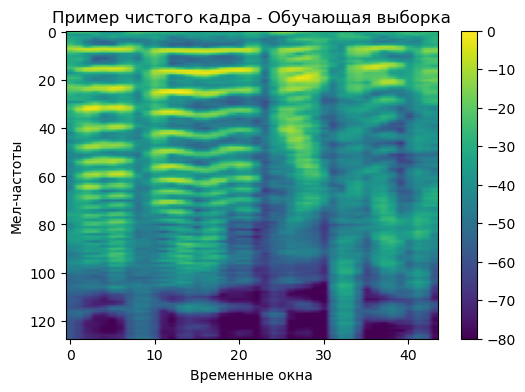

In [4]:
# Выбор случайного чистого кадра из обучающей выборки
clean_indices = np.where(y_train == 1)[0]
random_clean_index = random.choice(clean_indices)
clean_spectrogram = X_train[random_clean_index].reshape(target_shape)

plt.figure(figsize=(6, 4))
plt.imshow(clean_spectrogram, cmap='viridis', aspect='auto')
plt.title('Пример чистого кадра - Обучающая выборка')
plt.xlabel('Временные окна')
plt.ylabel('Мел-частоты')
plt.colorbar()
plt.show()


Этот блок выбирает случайный чистый кадр из обучающего набора данных и визуализирует его мел-спектрограмму с помощью matplotlib.
Это помогает понять, как выглядят спектрограммы чистых аудиосигналов.

# 5. Определение архитектуры модели CNN

In [5]:
# Определение архитектуры модели CNN
model = Sequential()

# Первый сверточный слой
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(target_shape[0], target_shape[1], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Второй сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Третий сверточный слой
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Выравнивание
model.add(Flatten())

# Полносвязный слой
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Выходной слой для бинарной классификации
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Вывод структуры модели
model.summary()


C:\Users\diate\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 42, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 19, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 9, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 7, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 3, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         688,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 781,057 (2.98 MB)

 Trainable params: 781,057 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

# В этом блоке определяется архитектура сверточной нейронной сети (CNN) с использованием Keras:

Сверточные слои: Три сверточных слоя с увеличивающимся числом фильтров (32, 64, 128) и размером ядра 3x3.
После каждого сверточного слоя следует слой MaxPooling для уменьшения размерности.

__Выравнивание:__ Преобразует многомерные выходы сверточных слоёв в одномерный вектор.

__Полносвязный слой:__ Содержит **128 нейронов с функцией активации ReLU** и слой Dropout для предотвращения переобучения.

__Выходной слой:__ Один нейрон с сигмоидной активацией для бинарной классификации **(чистый или шум)**.

__Компиляция:__ Модель компилируется с **оптимизатором Adam** и **функцией потерь binary_crossentropy**, метрика точности.


# 6. Обучение модели


In [6]:
# Обучение модели с использованием сбалансированных данных
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5995 - loss: 0.6552 - val_accuracy: 0.0000e+00 - val_loss: 1.7711
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6281 - loss: 0.5843 - val_accuracy: 0.6923 - val_loss: 0.7602
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9182 - loss: 0.2724 - val_accuracy: 0.9408 - val_loss: 0.2376
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9617 - loss: 0.1138 - val_accuracy: 0.9053 - val_loss: 0.3297
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9721 - loss: 0.1128 - val_accuracy: 0.9763 - val_loss: 0.1471
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9790 - loss: 0.0767 - val_accuracy: 0.9053 - val_loss: 0.3599
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9873 - loss: 0.0532 - val_accuracy: 0.9763 - val_loss: 0.1182
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9675 - loss: 0.0866 - val_accuracy: 0.9290

 Модель обучается на сбалансированных обучающих данных **(X_train_balanced, y_train_balanced)** в течение **20 эпох** с размером пакета 32. 
    
**20% данных используются для валидации модели во время обучения.**

История обучения сохраняется в переменной history для последующего анализа.

# 7. Оценка модели а тестовых данных

In [7]:
# Оценка модели на тестовых данных
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Точность модели на тестовых данных: {accuracy:.2f}')

# Получение прогнозов на тестовой выборке
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Вывод отчёта по классификации
print(classification_report(y_test, predicted_classes, target_names=['Шум', 'Чистый']))


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8605 - loss: 0.4299
Точность модели на тестовых данных: 0.91
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

         Шум       0.94      0.95      0.95      3366
      Чистый       0.79      0.75      0.77       803

    accuracy                           0.91      4169
   macro avg       0.86      0.85      0.86      4169
weighted avg       0.91      0.91      0.91      4169



__Оценка модели:__ Модель оценивается на тестовых данных, выводятся значения потерь и точности.
    
__Прогнозирование:__ Получаются прогнозы для всех тестовых данных, которые затем преобразуются в классы (0 или 1) на основе порога 0.5.
    
__Отчёт по классификации:__ Выводится подробный отчёт по классификации, включающий метрики **precision, recall, f1-score** для каждого класса.

# 8. Визулизация результатов

__8.1. Визуализация случайного предсказания__

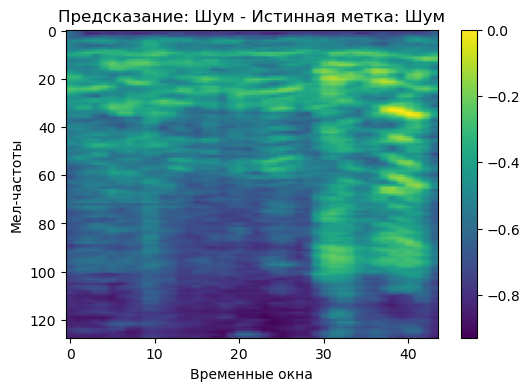

In [8]:
# Выбор случайного индекса из тестовой выборки
sample_index = random.randint(0, len(X_test) - 1)
sample_prediction = predicted_classes[sample_index]
sample_label = y_test[sample_index]
selected_class = "Чистый" if sample_prediction == 1 else "Шум"

# Визуализация спектрограммы выбранного кадра
sample_spectrogram = X_test[sample_index].reshape(target_shape)

plt.figure(figsize=(6, 4))
plt.imshow(sample_spectrogram, cmap='viridis', aspect='auto')
plt.title(f'Предсказание: {selected_class} - Истинная метка: {"Чистый" if sample_label == 1 else "Шум"}')
plt.xlabel('Временные окна')
plt.ylabel('Мел-частоты')
plt.colorbar()
plt.show()


Этот блок выбирает случайный пример из **тестового набора данных**, отображает его спектрограмму и показывает, как модель классифицировала этот пример по сравнению с истинной меткой.

__8.2. Визуализация первых 100 предсказаний__

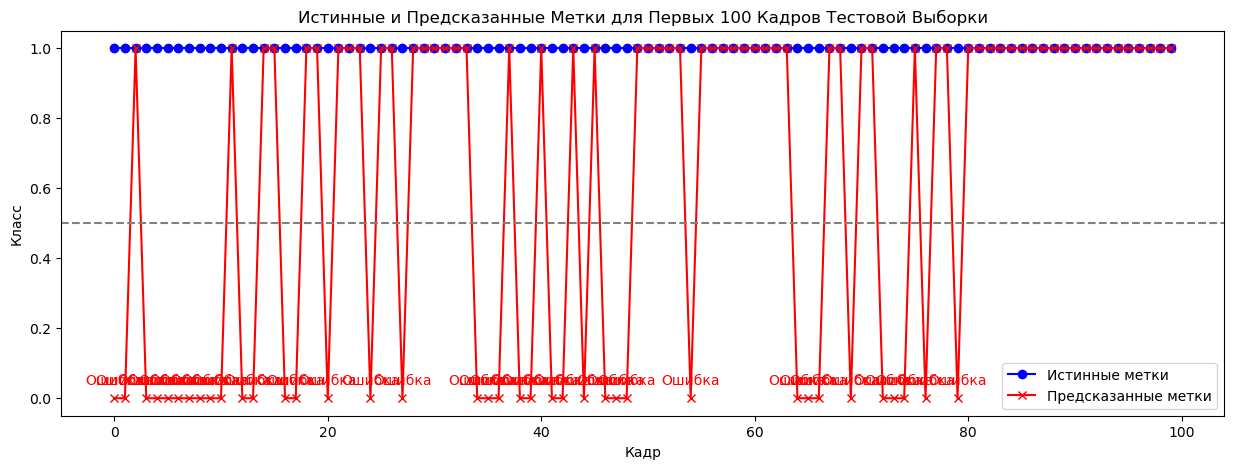

In [9]:
# Визуализация меток и прогнозов для первых 100 кадров тестовой выборки
num_samples = 100
plt.figure(figsize=(15, 5))
plt.plot(y_test[:num_samples], label='Истинные метки', marker='o', color='blue')
plt.plot(predicted_classes[:num_samples], label='Предсказанные метки', marker='x', color='red')

# Добавление аннотаций для ошибок
errors = np.where(y_test[:num_samples] != predicted_classes[:num_samples])[0]
for error in errors:
    plt.annotate('Ошибка', (error, predicted_classes[error]), textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.title('Истинные и Предсказанные Метки для Первых 100 Кадров Тестовой Выборки')
plt.xlabel('Кадр')
plt.ylabel('Класс')
plt.legend()
plt.axhline(y=0.5, color='grey', linestyle='--')  # Линия порога
plt.show()


Этот блок визуализирует истинные и предсказанные метки для первых 100 кадров тестового набора.
Ошибки классификации отмечены аннотациями, что помогает быстро выявить, где модель ошиблась.

__8.3. Визуализация кривых обучения__

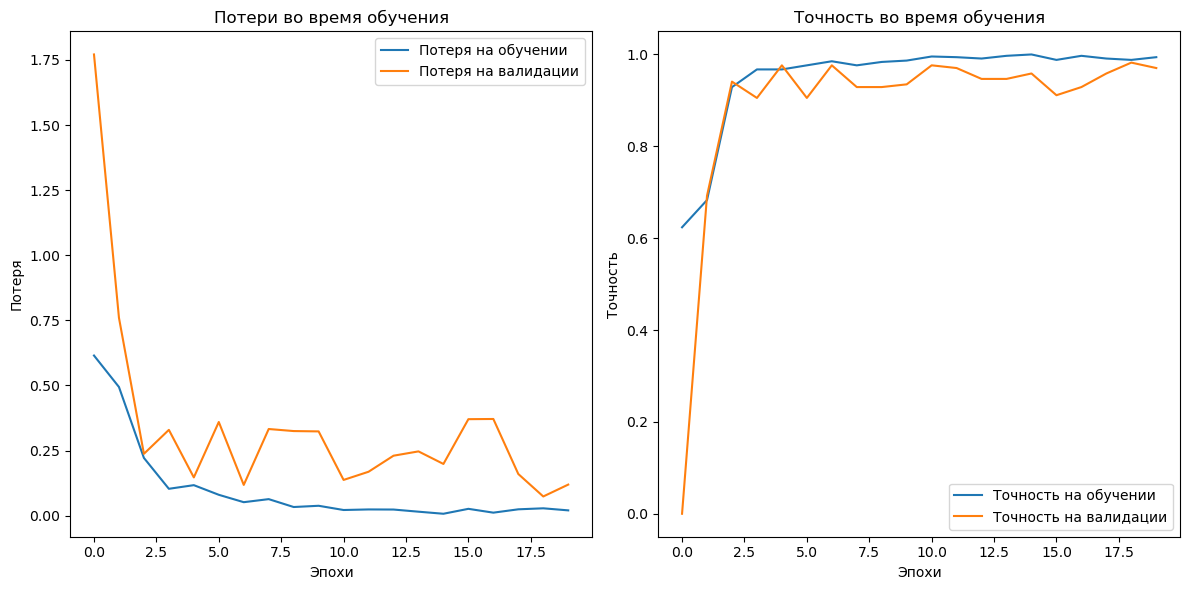

In [10]:
# Функция для построения кривых обучения
def plot_learning_curve(history):
    """
    Plota a curva de aprendizado para perda e precisão.
    """
    # Резюме потерь
    plt.figure(figsize=(12, 6))
    
    # Потери на обучении и валидации
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Потеря на обучении')
    plt.plot(history.history['val_loss'], label='Потеря на валидации')
    plt.title('Потери во время обучения')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря')
    plt.legend()
    
    # Точность на обучении и валидации
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Точность на обучении')
    plt.plot(history.history['val_accuracy'], label='Точность на валидации')
    plt.title('Точность во время обучения')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Вызов функции для построения кривых обучения
plot_learning_curve(history)


 Функция **plot_learning_curve** строит графики **потерь и точности** для **обучающего и валидационного наборов данных по эпохам**.
Это помогает оценить, как модель обучалась и выявить возможные проблемы, такие как переобучение.

# 8.4. Матрица путаницы

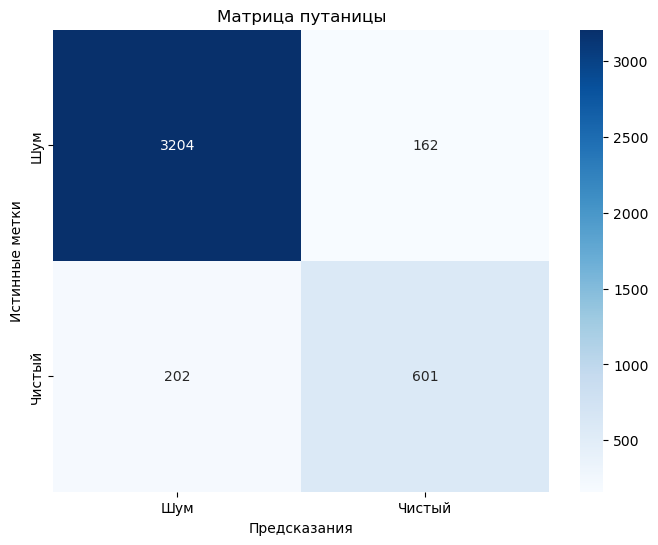

In [11]:
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Шум', 'Чистый'], yticklabels=['Шум', 'Чистый'])
plt.xlabel('Предсказания')
plt.ylabel('Истинные метки')
plt.title('Матрица путаницы')
plt.show()


Этот блок строит матрицу путаницы с помощью seaborn, что позволяет визуально оценить количество **истинных положительных, истинных отрицательных, ложных положительных и ложных отрицательных** классификаций модели.

# 9. Дополнительная проверка модели на обнаружение чистого сигнала в шумном

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Чистый сигнал НЕ был найден в шумном сигнале.


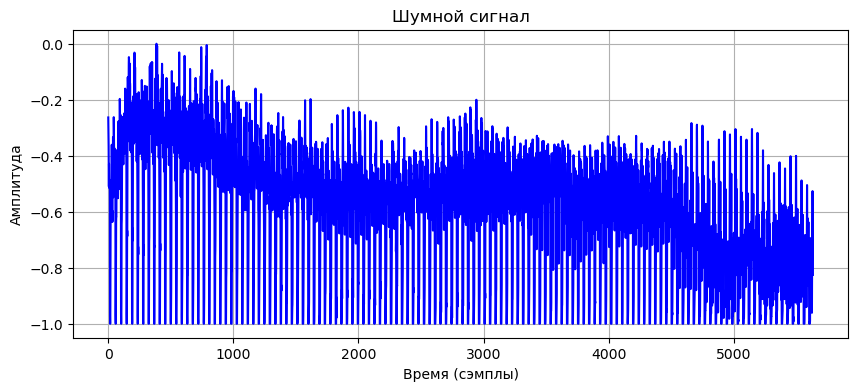

In [12]:
# Функция для извлечения характеристик сигнала из модели
def extract_features_from_model(signal, model):
    # Преобразует сигнал в форму, ожидаемую моделью
    signal_reshape = signal.reshape(1, *signal.shape)  # Добавляет новую размерность
    return model.predict(signal_reshape)

# Функция для проверки, найден ли чистый сигнал в шумном
def verify_clean_signal_in_noisy(noisy_signal, clean_signal, model):
    segment_size = 22050  # Размер сегмента в сэмплах (например, 1 секунда)
    segments = [noisy_signal[i:i + segment_size] for i in range(0, len(noisy_signal), segment_size) if i + segment_size <= len(noisy_signal)]
    
    # Переменная для хранения результатов
    results = []
    
    # Прогноз для чистого сигнала через модель
    clean_features = extract_features_from_model(clean_signal, model)
    
    # Проверка каждого сегмента
    for segment in segments:
        # Извлечение характеристик сегмента с помощью модели
        segment_features = extract_features_from_model(segment, model)
        
        # Сравнение прогнозов сегмента и чистого сигнала
        if segment_features > 0.5 and clean_features > 0.5:
            results.append(True)
        else:
            results.append(False)
    
    return results

# Пример использования
clean_signal = X_test[0]  # Выбирает чистый сигнал для теста
noisy_signal = X_test[1]  # Выбирает шумной сигнал для теста

results = verify_clean_signal_in_noisy(noisy_signal, clean_signal, model)
if any(results):
    print("Чистый сигнал был найден в шумном сигнале.")
else:
    print("Чистый сигнал НЕ был найден в шумном сигнале.")

# Визуализация шумного сигнала (только один сигнал)
plt.figure(figsize=(10, 4))  # Настройка размера фигуры при необходимости
plt.plot(noisy_signal.flatten(), color='blue')  # Использовать flatten, если это многомерный массив
plt.title("Шумной сигнал")
plt.xlabel("Время (сэмплы)")
plt.ylabel("Амплитуда")
plt.grid(True)  # Добавляет сетку для лучшей визуализации
plt.show()


**Извлечение характеристик:** Функция extract_features_from_model использует обученную модель для получения прогнозов по заданному сигналу.
    
**Проверка чистого сигнала в шумном:** Функция verify_clean_signal_in_noisy разделяет шумной сигнал на сегменты и проверяет, присутствует ли чистый сигнал среди этих сегментов, сравнивая прогнозы модели.

**Пример использования:** Проверяется, присутствует ли чистый сигнал в шумном сигнале, и выводится соответствующее сообщение.
    
**Визуализация:** Шумной сигнал визуализируется для наглядности.